<a href="https://colab.research.google.com/github/Uniholder/DeepLearningSchool/blob/main/2_semester/2_Embeddings/%5Bhomework%5Dembeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Embeddings

Привет! В этом домашнем задании мы с помощью эмбеддингов решим задачу семантической классификации твитов.

Для этого мы воспользуемся предобученными эмбеддингами word2vec.

Для начала скачаем датасет для семантической классификации твитов:

In [ ]:
# !gdown --id 1eE1FiUkXkcbw0McId4i7qY-L8hH-_Qph
# !unzip archive.zip

Импортируем нужные библиотеки:

In [1]:
import math
import random
import string
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(13, 8)})

import torch
import nltk
import gensim
import gensim.downloader as api

In [4]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
PATH_TO_DATA = os.path.join('..', 'data')

In [5]:
data = pd.read_csv(
    os.path.join(PATH_TO_DATA, "training.1600000.processed.noemoticon.csv"),
    encoding="latin", 
    header=None, 
    names=["emotion", "id", "date", "flag", "user", "text"]
)

Посмотрим на данные:

In [6]:
data

,emotion,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Выведем несколько примеров твитов, чтобы понимать, с чем мы имеем дело:

In [7]:
examples = data["text"].sample(10)
print("\n".join(examples))

@chrishasboobs AHHH I HOPE YOUR OK!!! 
@misstoriblack cool , i have no tweet apps  for my razr 2
@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
upper airways problem 
Going to miss Pastor's sermon on Faith... 
on lunch....dj should come eat with me 
@piginthepoke oh why are you feeling like that? 
gahh noo!peyton needs to live!this is horrible 
@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!


Как видим, тексты твитов очень "грязные". Нужно предобработать датасет, прежде чем строить для него модель классификации.

Чтобы сравнивать различные методы обработки текста/модели/прочее, разделим датасет на dev(для обучения модели) и test(для получения качества модели).

In [8]:
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
dev_size = math.ceil(data.shape[0] * 0.8)

dev_indexes = indexes[:dev_size]
test_indexes = indexes[dev_size:]

dev_data = data.iloc[dev_indexes]
test_data = data.iloc[test_indexes]

dev_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

## Обработка текста

Токенизируем текст, избавимся от знаков пунктуации и выкинем все слова, состоящие менее чем из 4 букв:

In [9]:
tokenizer = nltk.WordPunctTokenizer()
line = tokenizer.tokenize(dev_data["text"][0].lower())
print(" ".join(line))

@ claire_nelson i ' m on the north devon coast the next few weeks will be down in devon again in may sometime i hope though !


In [10]:
filtered_line = [w for w in line if all(c not in string.punctuation for c in w) and len(w) > 3]
print(" ".join(filtered_line))

north devon coast next weeks will down devon again sometime hope though


Загрузим предобученную модель эмбеддингов. 

Если хотите, можно попробовать другую. Полный список можно найти здесь: https://github.com/RaRe-Technologies/gensim-data.

Данная модель выдает эмбеддинги для **слов**. Строить по эмбеддингам слов эмбеддинги предложений мы будем ниже.

In [11]:
word2vec = api.load("word2vec-google-news-300")

In [12]:
emb_line = [word2vec.get_vector(w) for w in filtered_line if w in word2vec]
print(sum(emb_line).shape)

(300,)


Нормализуем эмбеддинги, прежде чем обучать на них сеть. 
(наверное, вы помните, что нейронные сети гораздо лучше обучаются на нормализованных данных)

In [13]:
mean = np.mean(word2vec.vectors, 0)
std = np.std(word2vec.vectors, 0)
norm_emb_line = [(word2vec.get_vector(w) - mean) / std for w in filtered_line if w in word2vec and len(w) > 3]  #
print(sum(norm_emb_line).shape)
print([all(norm_emb_line[i] == emb_line[i]) for i in range(len(emb_line))])

(300,)
[False, False, False, False, False, False, False, False, False, False, False, False]


Сделаем датасет, который будет по запросу возвращать подготовленные данные.

In [14]:
from torch.utils.data import Dataset, random_split


class TwitterDataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)
        

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}
    

    def get_tokens_(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        filtered_tokens = [t for t in tokens if all(ch not in string.punctuation for ch in t) and len(t) > 3]
        
        return filtered_tokens
    

    def get_embeddings_(self, tokens):
        embeddings = [(self.word2vec.get_vector(t) - self.mean) / self.std for t in tokens if t in self.word2vec]

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return embeddings
    

    def __len__(self):
        return self.data.shape[0]

In [15]:
dev = TwitterDataset(dev_data, "text", "emotion", word2vec)

Отлично, мы готовы с помощью эмбеддингов слов превращать твиты в векторы и обучать нейронную сеть.

Превращать твиты в векторы, используя эмбеддинги слов, можно несколькими способами. А именно такими:

## Average embedding (2 балла)
---
Это самый простой вариант, как получить вектор предложения, используя векторные представления слов в предложении. А именно: вектор предложения есть средний вектор всех слов в предложении (которые остались после токенизации и удаления коротких слов, конечно). 

In [16]:
indexes = np.arange(len(dev))
np.random.shuffle(indexes)
example_indexes = indexes[::1000]

examples = {"features": [np.sum(dev[i]["feature"], axis=0) for i in example_indexes], 
            "targets": [dev[i]["target"] for i in example_indexes]}
print(len(examples["features"]))

1280


Давайте сделаем визуализацию полученных векторов твитов тренировочного (dev) датасета. Так мы увидим, насколько хорошо твиты с разными target значениями отделяются друг от друга, т.е. насколько хорошо усреднение эмбеддингов слов предложения передает информацию о предложении.

Для визуализации векторов надо получить их проекцию на плоскость. Сделаем это с помощью `PCA`. Если хотите, можете вместо PCA использовать TSNE: так у вас получится более точная проекция на плоскость (а значит, более информативная, т.е. отражающая реальное положение векторов твитов в пространстве). Но TSNE будет работать намного дольше.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
examples["transformed_features"] = pca.fit_transform(np.array(examples['features']))

In [18]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue', width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
        
    return fig

Loading BokehJS ...

In [19]:
draw_vectors(
    examples["transformed_features"][:, 0], 
    examples["transformed_features"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1004', ...)

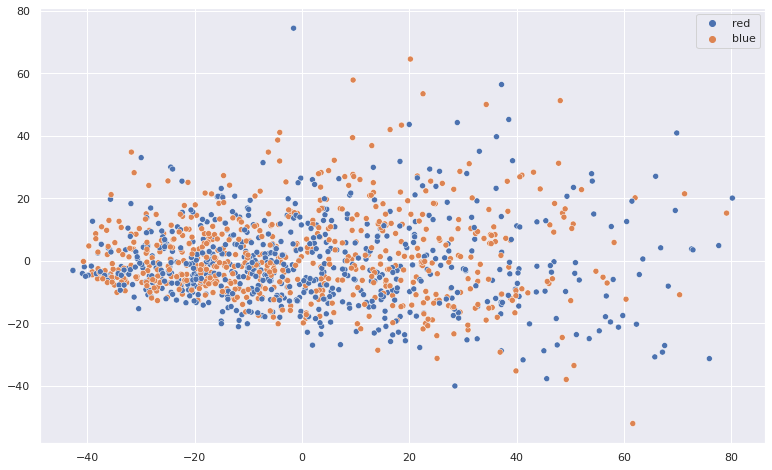

In [20]:
sns.scatterplot(
    x=examples["transformed_features"][:, 0], 
    y=examples["transformed_features"][:, 1],
    hue=[["red", "blue"][t] for t in examples["targets"]]
);

In [21]:
# !pip install MulticoreTSNE

In [22]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=4)
examples["transformed_features_tsne"]= tsne.fit_transform(np.array(examples['features']))

In [23]:
draw_vectors(
    examples["transformed_features_tsne"][:, 0], 
    examples["transformed_features_tsne"][:, 1], 
    color=[["red", "blue"][t] for t in examples["targets"]]
    )

Figure(id='1113', ...)

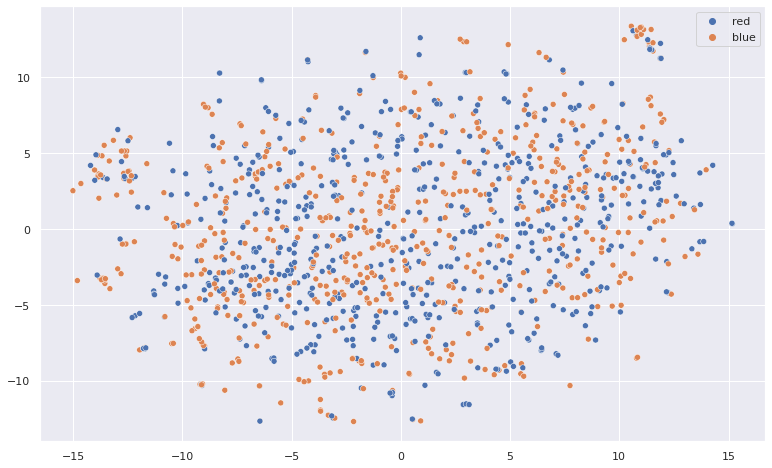

In [24]:
sns.scatterplot(
    x=examples["transformed_features_tsne"][:, 0], 
    y=examples["transformed_features_tsne"][:, 1],
    hue=[["red", "blue"][t] for t in examples["targets"]]
);

Скорее всего, на визуализации нет четкого разделения твитов между классами. Это значит, что по полученным нами векторам твитов не так-то просто определить, к какому классу твит пренадлежит. Значит, обычный линейный классификатор не очень хорошо справится с задачей. Надо будет делать глубокую (хотя бы два слоя) нейронную сеть.

Подготовим загрузчики данных.
Усреднее векторов будем делать в "батчевалке"(`collate_fn`). Она используется для того, чтобы собирать из данных `torch.Tensor` батчи, которые можно отправлять в модель.


In [25]:
from torch.utils.data import DataLoader


batch_size = 1024
num_workers = 2

def average_emb(batch):
    features = [np.mean(b["feature"], axis=0) for b in batch]
    targets = [b["target"] for b in batch]

    return {"features": torch.FloatTensor(features), "targets": torch.LongTensor(targets)}


train_size = math.ceil(len(dev) * 0.8)

train, valid = random_split(dev, [train_size, len(dev) - train_size])

train_loader = DataLoader(
    train, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True, 
    drop_last=True, 
    collate_fn=average_emb
)
valid_loader = DataLoader(
    valid, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False, 
    drop_last=False, 
    collate_fn=average_emb
)

Определим функции для тренировки и теста модели:

In [40]:
from tqdm.notebook import tqdm


def training(model, optimizer, criterion, train_loader, epoch, device="cpu"):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}. Train Loss: ")
    model.train()
    for batch in pbar:
        features = batch["features"].to(device)
        targets = batch["targets"].to(device)
        break

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {e + 1}. Train Loss: {loss:.4}")
    

def testing(model, criterion, test_loader, device="cpu"):
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    mean_loss = 0
    mean_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in pbar:
            features = batch["features"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(features)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, 1)
            acc = torch.sum(preds == targets) / len(targets)

            mean_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

    pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")

    return {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader)}

Создадим модель, оптимизатор и целевую функцию. Вы можете сами выбрать количество слоев в нейронной сети, ваш любимый оптимизатор и целевую функцию.


In [27]:
import torch.nn as nn
from torch.optim import Adam


vector_size = dev.word2vec.vector_size
num_classes = 2
lr = 1e-3
num_epochs = 1

model = nn.Sequential(
  nn.Linear(vector_size, 32),
  nn.ReLU(),
  # nn.Linear(128, 32),
  # nn.ReLU(),
  nn.Linear(32, num_classes)
)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)  # betas=(0.9, 0.99)

Наконец, обучим модель и протестируем её.

После каждой эпохи будем проверять качество модели на валидационной части датасета. Если метрика стала лучше, будем сохранять модель. **Подумайте, какая метрика (точность или лосс) будет лучше работать в этой задаче?** 

In [30]:
best_metric = np.inf
for e in range(num_epochs):
    training(model, optimizer, criterion, train_loader, e, device)
    log = testing(model, criterion, valid_loader, device)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]

Epoch 1. Train Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Loss: 0, Test Acc: 0:   0%|          | 0/250 [00:00<?, ?it/s]

{'Test Loss': 0.5218908381462097, 'Test Acc': 0.7391015625}


In [31]:
test_loader = DataLoader(
    TwitterDataset(test_data, "text", "emotion", word2vec), 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False,
    drop_last=False, 
    collate_fn=average_emb)

model.load_state_dict(torch.load("model.pt", map_location=device))

print(testing(model, criterion, test_loader, device=device))

Test Loss: 0, Test Acc: 0:   0%|          | 0/313 [00:00<?, ?it/s]

{'Test Loss': 0.5238380892969929, 'Test Acc': 0.7375823682108626}


## Embeddings for unknown words (8 баллов)

Пока что использовалась не вся информация из текста. Часть информации фильтровалось – если слова не было в словаре эмбеддингов, то мы просто превращали слово в нулевой вектор. Хочется использовать информацию по-максимуму. Поэтому рассмотрим другие способы обработки слов, которых нет в словаре. А именно:

- Для каждого незнакомого слова будем запоминать его контекст(слова слева и справа от этого слова). Эмбеддингом нашего незнакомого слова будет сумма эмбеддингов всех слов из его контекста. (4 балла)
- Для каждого слова текста получим его эмбеддинг из Tfidf с помощью ```TfidfVectorizer``` из [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Итоговым эмбеддингом для каждого слова будет сумма двух эмбеддингов: предобученного и Tfidf-ного. Для слов, которых нет в словаре предобученных эмбеддингов, результирующий эмбеддинг будет просто полученный из Tfidf. (4 балла)

Реализуйте оба варианта **ниже**. Напишите, какой способ сработал лучше и ваши мысли, почему так получилось.

In [59]:
from torch.utils.data import Dataset, random_split


class TwitterDataset2(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_column: str, word2vec: gensim.models.Word2Vec):
        self.tokenizer = nltk.WordPunctTokenizer()
        
        self.data = data

        self.feature_column = feature_column
        self.target_column = target_column

        self.word2vec = word2vec

        self.label2num = lambda label: 0 if label == 0 else 1
        self.mean = np.mean(word2vec.vectors, axis=0)
        self.std = np.std(word2vec.vectors, axis=0)
        

    def __getitem__(self, item):
        text = self.data[self.feature_column][item]
        label = self.label2num(self.data[self.target_column][item])

        tokens = self.get_tokens_(text)
        embeddings = self.get_embeddings_(tokens)

        return {"feature": embeddings, "target": label}
    

    def get_tokens_(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        filtered_tokens = [t for t in tokens if all(ch not in string.punctuation for ch in t) and len(t) > 3]
        
        return filtered_tokens
    

    def get_embeddings_(self, tokens):
        embeddings = []
        window = 2
        for t in tokens:
            if t in self.word2vec:
                embeddings.append((self.word2vec.get_vector(t) - self.mean) / self.std)
            else:
#                 pass
                embeddings.append('<UNK>')

        for i, e in enumerate(embeddings):
            if e == '<UNK>':
                start_idx = max(0, i - window)
                end_idx = min(i + window, len(embeddings))
                context = embeddings[start_idx:end_idx]
                print(type(context))
                context = context[context != '<UNK>']
                unk_embed = context.sum(axis=0)
#                 print(unk_embed)
                embeddings[i] = unk_embed

        if len(embeddings) == 0:
            embeddings = np.zeros((1, self.word2vec.vector_size))
        else:
            embeddings = np.array(embeddings)
            if len(embeddings.shape) == 1:
                embeddings = embeddings.reshape(-1, 1)

        return np.array(embeddings)
    

    def __len__(self):
        return self.data.shape[0]

In [60]:
%%time
dev2 = TwitterDataset2(dev_data, "text", "emotion", word2vec)

train2, valid2 = random_split(dev2, [train_size, len(dev) - train_size])

train_loader2 = DataLoader(
    train2, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True, 
    drop_last=True, 
    collate_fn=average_emb
)
valid_loader2 = DataLoader(
    valid2, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False, 
    drop_last=False, 
    collate_fn=average_emb
)

CPU times: user 2.21 s, sys: 840 ms, total: 3.05 s
Wall time: 2.96 s


In [61]:
best_metric = np.inf
for e in range(num_epochs):
    training(model, optimizer, criterion, train_loader2, e, device)
    log = testing(model, criterion, valid_loader, device)
    print(log)
    if log["Test Loss"] < best_metric:
        torch.save(model.state_dict(), "model.pt")
        best_metric = log["Test Loss"]

Epoch 1. Train Loss:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-59-23399a82f31a>:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if e == '<UNK>':
<ipython-input-59-23399a82f31a>:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if e == '<UNK>':


<class 'list'>
<class 'list'>

<ipython-input-59-23399a82f31a>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  embeddings = np.array(embeddings)



<class 'list'>
<class 'list'><class 'list'>



<ipython-input-59-23399a82f31a>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  embeddings = np.array(embeddings)


<class 'list'><class 'list'>

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'><class 'list'>

<class 'list'>
<class 'list'>

<class 'list'>
<class 'list'><class 'list'><class 'list'>

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/uniholder/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/uniholder/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/uniholder/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/uniholder/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 330, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<ipython-input-59-23399a82f31a>", line 25, in __getitem__
    embeddings = self.get_embeddings_(tokens)
  File "<ipython-input-59-23399a82f31a>", line 54, in get_embeddings_
    unk_embed = context.sum(axis=0)
AttributeError: 'str' object has no attribute 'sum'


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
